<a href="https://colab.research.google.com/github/Chenxi-yi/deep-learning-/blob/master/pytorch_alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
 
"""### 挂载到google drive上""" 
from google.colab import drive

# 使用工具colab的接口挂载google drive目录，这样可以从外部获取数据并且可以把训练好的模型保存在google drive上
drive.mount('/content/gdrive')
#model.save('/content/gdrive/My Drive/DL/mnist_model.h5')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path="/content/gdrive/My Drive/DL/small set"

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import transforms
from torchvision import models
from torchvision.models import ResNet
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import os


In [0]:
 !pip install imutils

In [0]:
def load_split_train_test(path,valid_size = 0.2):
  train_trainsforms = transforms.Compose([#transforms.RandomResizedCrop(256),# formal 224
                                            transforms.Resize(256),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize(
                                            mean=(0.5, 0.5, 0.5), # formal (0.485, 0.456, 0.406)
                                            std=(0.5, 0.5, 0.5))  # formal (0.229, 0.224, 0.225)
                                                     ])
  test_trainsforms = transforms.Compose([#transforms.RandomResizedCrop(256),
                                            transforms.Resize(256),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize(
                                            mean=(0.5, 0.5, 0.5),
                                            std=(0.5, 0.5, 0.5))
                                                     ])
  
  '''
   train_trainsforms = transforms.Compose([transforms.Resize((224,224)),
                                            transforms.ToTensor(),])
    test_trainsforms = transforms.Compose([transforms.Resize((224,224)),                                      
                                           transforms.ToTensor(),])
  
  '''

  train_data = datasets.ImageFolder(path,transform=train_trainsforms)
  print("train_data size：",train_data[0][0].size())       # 查看resize(确保图像都有3通道)
  test_data = datasets.ImageFolder(path,transform=test_trainsforms)

  num_train = len(train_data)                               # 训练集数量
  indices = list(range(num_train))                          # 训练集索引

  split = int(np.floor(valid_size * num_train))             # 获取20%数据作为验证集
  np.random.shuffle(indices)                                # 打乱数据集

  from torch.utils.data.sampler import SubsetRandomSampler
  train_idx, test_idx = indices[split:], indices[:split]    # 获取训练集，测试集
  train_sampler = SubsetRandomSampler(train_idx)            # 打乱训练集，测试集
  test_sampler  = SubsetRandomSampler(test_idx)

    #============数据加载器：加载训练集，测试集===================
  batch_size = 4
  train_loader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)
  test_loader = DataLoader(test_data,sampler=test_sampler,batch_size=batch_size)
  return train_loader,test_loader

In [0]:
train_loader,test_loader = load_split_train_test(path, 0.2)
print(train_loader.dataset.classes)

train_data size： torch.Size([3, 256, 384])
['Alpine Butterfly Knot', 'Bowline Knot', 'Clove Hitch', 'Figure-8 Knot', 'Figure-8 Loop', "Fisherman's Knot", 'Flemish Bend', 'Overhand Knot', 'Reef Knot', 'Slip Knot']


In [0]:
class_names = train_loader.dataset.classes

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('trian_device:{}'.format(device.type))


trian_device:cuda


Alpine Butterfly Knot Figure-8 Knot Bowline Knot Figure-8 Loop


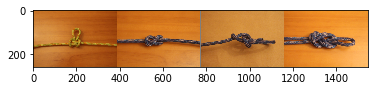

In [0]:
import matplotlib.pyplot as plt
import numpy as np
 
# functions to show an image
 
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
 
 
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
 
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
batch_size = 4
print(' '.join('%5s' % class_names[labels[j]] for j in range(batch_size)))
images, labels = images.to(device), labels.to(device)


In [0]:
import torch.nn as nn
import torch.nn.functional as F


In [0]:
import torchvision.models as models
#alexnet = models.alexnet(pretrained=True)
alexnet = models.alexnet(num_classes = 10)
alexnet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [0]:
import torch.optim as optim
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.01, momentum=0.9)

In [0]:
for epoch in range(1):  # loop over the dataset multiple times
 
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
 
        # zero the parameter gradients
        optimizer.zero_grad()
 
        # forward + backward + optimize
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()      
        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
 
 
print('Finished Training')

[1,    20] loss: 2.295
[1,    40] loss: 2.313
[1,    60] loss: 2.318
[1,    80] loss: 2.329
Finished Training


GroundTruth:  Bowline Knot Clove Hitch Flemish Bend Clove Hitch


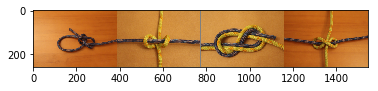

In [0]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
 
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(batch_size)))
images, labels = images.to(device), labels.to(device)


In [0]:

outputs = alexnet(images)
_, predicted = torch.max(outputs, 1)
 
print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(batch_size)))


Predicted:  Bowline Knot Bowline Knot Bowline Knot Bowline Knot


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 100 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 100 test images: 8 %


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]),
          'class_correct = ',class_correct[i],
         'class_total = ',class_total[i])
  

Accuracy of Alpine Butterfly Knot :  0 % class_correct =  0.0 class_total =  13.0
Accuracy of Bowline Knot : 100 % class_correct =  8.0 class_total =  8.0
Accuracy of Clove Hitch :  0 % class_correct =  0.0 class_total =  14.0
Accuracy of Figure-8 Knot :  0 % class_correct =  0.0 class_total =  10.0
Accuracy of Figure-8 Loop :  0 % class_correct =  0.0 class_total =  7.0
Accuracy of Fisherman's Knot :  0 % class_correct =  0.0 class_total =  8.0
Accuracy of Flemish Bend :  0 % class_correct =  0.0 class_total =  9.0
Accuracy of Overhand Knot :  0 % class_correct =  0.0 class_total =  7.0
Accuracy of Reef Knot :  0 % class_correct =  0.0 class_total =  9.0
Accuracy of Slip Knot :  0 % class_correct =  0.0 class_total =  11.0
